In [2]:
from bs4 import BeautifulSoup
import requests

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from time import sleep

import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib
#from matplotlib import rcParams
matplotlib.use('tkAgg', force=True)
from matplotlib.lines import Line2D

import seaborn as sns
import collections

import pandas as pd
import numpy as np
    
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use('seaborn-poster')

In [3]:
#font_manager.fontManager.ttflist

In [5]:
base_url = 'https://beta7.app/'

#### Selenium - get all routes

In [85]:
driver = webdriver.Firefox()

# Go to routes page:
driver.get(base_url + "location/bertablock/routes")
sleep(3)

# load more than 16 routes:
driver.find_element("xpath", "//span[.='load more']").click()
sleep(4)

# scrall down:
for i in range(60):
    driver.execute_script("window.scrollTo(0, 50000)") 
    sleep(0.5)

In [86]:
# get the entire html of the routes page
html = driver.page_source
# close the driver 
driver.close()

In [208]:
# format the html to soup
soup = BeautifulSoup(html, 'html.parser')

#### Create all routes df:
Number of sends might be different here and in route link below (as people might send in the meanwhile)

In [209]:
all_routes_soup = soup.find_all('div', {'class':'route-container'})
n_routes = len(all_routes_soup)
n_routes

360

In [210]:
#all_routes_soup[0]

In [233]:
routes_section = []
routes_color = []
routes_name = []
routes_grade = []
routes_grade_gym = []
routes_holdtypes = []
routes_style = []
routes_time = []
routes_nclimbs = []

# Get routes link:
routes_hrefs = [a['href'] for a in soup.find_all('a', href=True) if 'route/' in a['href']]
if len(routes_hrefs)!=n_routes:
    print('mismatch in #route links to #links')

for r_soup in all_routes_soup:
    routes_section.append(r_soup.find('span', {'class':"additional-location-information"}).text)
    routes_color.append(r_soup.find_all('span', {'class':"color"})[-1].text)
    routes_holdtypes.append(r_soup.find('span', {'class':"holdtypes"}).text)
    routes_style.append([s.text.replace('\u200d','') for s in r_soup.find_all('span', {'class':"style"})])
    routes_time.append(r_soup.find('time', {'class':"hint"}).text)

    name = r_soup.find('span', {'class':"route-name"})
    name = name.text if name else ''
    routes_name.append(name)
    
    grade = r_soup.find('span', {'class':"grades"}).text.split('/')
    routes_grade.append(grade[0])
    routes_grade_gym.append(grade[1])
    
    n_climbs = r_soup.find_all('span', {'class':"climbs-count"})
    ## "climbs-count" might be senders/beta requests/videos
    ## if isnumeric returns false than its the number of beta requests/videos.
    n_climbs = float(n_climbs[-1].text.rstrip()) if (
        n_climbs and n_climbs[-1].text.rstrip().isnumeric()) else float('nan')

    routes_nclimbs.append(n_climbs)

    

In [347]:
df_all_routes = pd.DataFrame({
    'section':routes_section,
    'grade':routes_grade,
    'grade_gym':routes_grade_gym,
    'color':routes_color,
    'name':routes_name,
    'holdtypes':routes_holdtypes,
    'styles':routes_style,
    'time':routes_time,
    'href':routes_hrefs,
    'nclimbs':routes_nclimbs,
})

In [378]:
holdtypes = ["pockets","jugs","volumes","pinches","crimps","slopers"]

for h in holdtypes:
    df_all_routes[h] = df_all_routes.holdtypes.str.contains(h)


In [390]:
styles = {"💎":"compression",
          "🔬":"technique",
          "💪":"strength",
          "💣":"power",
          "🤸":"fun",
          "🧘":"balance",
          "💢":"corner",
          "💃":"footwork",
          "🤹":"coordination",
          "🚪":"arete",
          "🏄":"mantle",
          "🚀":"dyno",
          "🔥":"endurance"
         }

for key,val in styles.items():
    df_all_routes[val] = df_all_routes.apply(lambda x: key in x['styles'], axis=1)



In [391]:
df_all_routes.head()

,section,grade,grade_gym,color,name,holdtypes,styles,time,href,nclimbs,...,power,fun,balance,corner,footwork,coordination,arete,mantle,dyno,endurance
0,Karma,7A,SCHWARZ,pink,,"crimps, pinches & slopers","[💎, 🔬, 💪]",3 hours ago,/route/oPyelLHG1UTKGwdDHcqJ1OIzt383~1663690212790,2.0,...,False,False,False,False,False,False,False,False,False,False
1,Karma,6C,LILA,black,,slopers & crimps,"[💣, 💎]",3 hours ago,/route/oPyelLHG1UTKGwdDHcqJ1OIzt383~1663690057778,1.0,...,True,False,False,False,False,False,False,False,False,False
2,Karma,6A,BLAU,blue,,jugs & pinches,"[🤸, 💣]",3 hours ago,/route/oPyelLHG1UTKGwdDHcqJ1OIzt383~1663689956983,4.0,...,True,True,False,False,False,False,False,False,False,False
3,Karma,4,GELB,orange,,crimps,"[🧘, 💪]",3 hours ago,/route/oPyelLHG1UTKGwdDHcqJ1OIzt383~1663689818869,1.0,...,False,False,True,False,False,False,False,False,False,False
4,Karma,5+,GRÜN,yellow,,slopers,"[🧘, 💢]",3 hours ago,/route/oPyelLHG1UTKGwdDHcqJ1OIzt383~1663689750330,NaN,...,False,False,True,True,False,False,False,False,False,False


### Summarize

[Text(0.5, 1.0, 'number of routes per grade')]

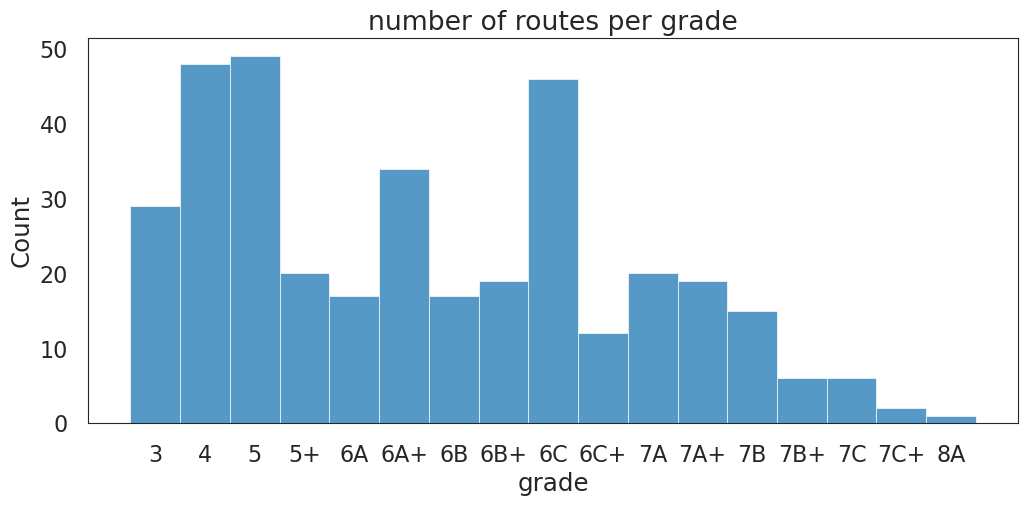

In [412]:
sns.set_style("white")
plt.figure(figsize=(12,5))
sns.histplot(df_all_routes.sort_values(by=["grade"]), x='grade').set(title='number of routes per grade')

[Text(0.5, 1.0, 'mean number of sends per grade')]

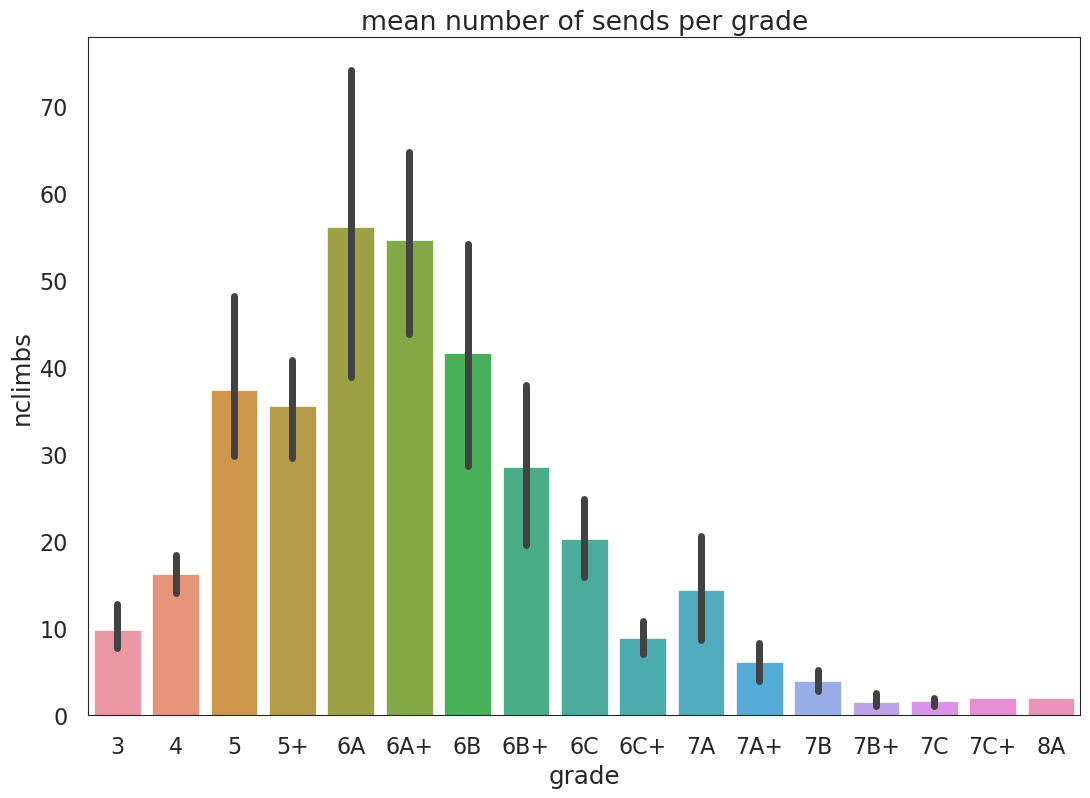

In [413]:
sns.barplot(data=df_all_routes.sort_values(by=["grade"]), x='grade', y='nclimbs').set(title='mean number of sends per grade')

In [393]:
df_grade_holdtype = df_all_routes.groupby(['grade'])[holdtypes].sum()
df_grade_holdtype['counter'] = df_all_routes.groupby(['grade']).size()

df_grade_holdtype = df_grade_holdtype.reset_index()

<AxesSubplot:title={'center':'hold type'}, xlabel='grade'>

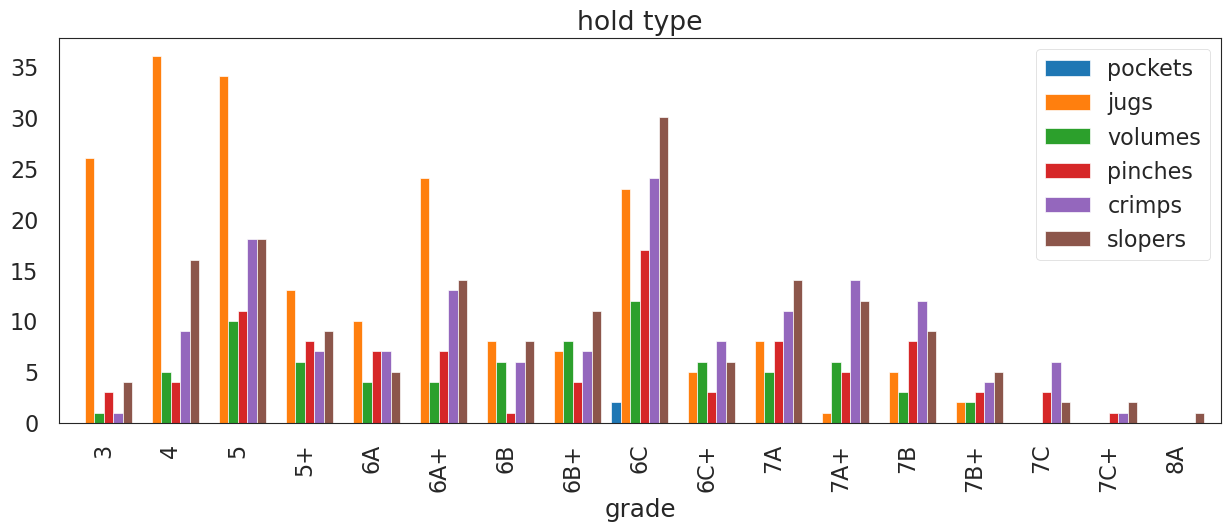

In [394]:
df_grade_holdtype.plot(x="grade", y=holdtypes, width=0.85,
                       kind="bar",figsize=(15,5), title='hold type')

In [395]:
df_grade_holdtype.iloc[:,1:-1] = df_grade_holdtype.iloc[:,1:-1].div(df_grade_holdtype.counter, axis=0)

<AxesSubplot:title={'center':'hold type - normalized'}, xlabel='grade'>

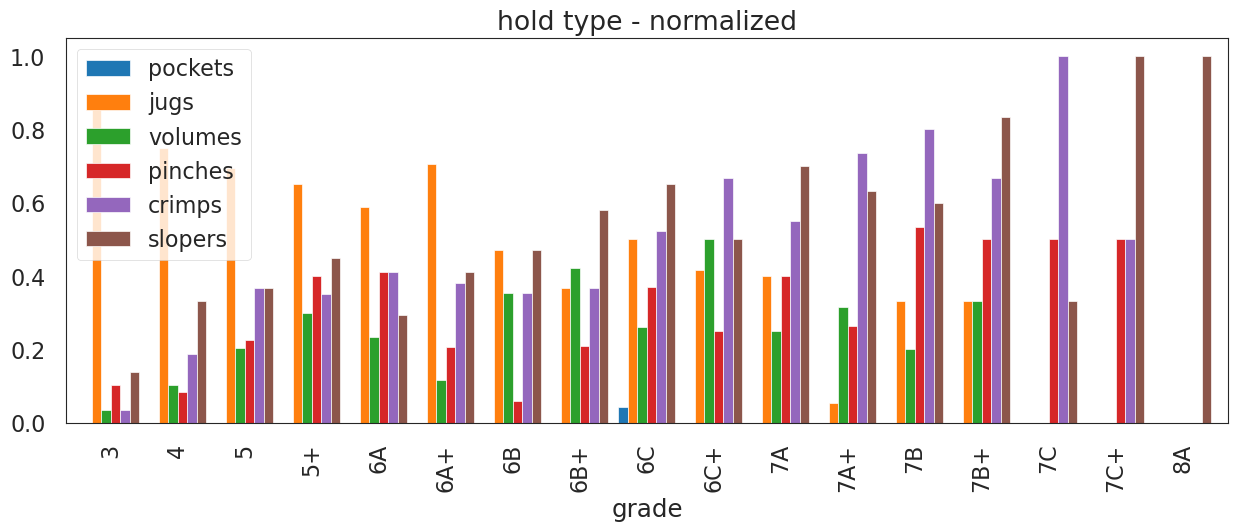

In [396]:
df_grade_holdtype.plot(x="grade", y=holdtypes, 
                       kind="bar",figsize=(15,5), width=0.85, title='hold type - normalized')

In [402]:
styles.values()

dict_values(['compression', 'technique', 'strength', 'power', 'fun', 'balance', 'corner', 'footwork', 'coordination', 'arete', 'mantle', 'dyno', 'endurance'])

In [403]:
df_grade_style = df_all_routes.groupby(['grade'])[list(styles.values())].sum()
df_grade_style['counter'] = df_all_routes.groupby(['grade']).size()

df_grade_style = df_grade_style.reset_index()

<AxesSubplot:title={'center':'style'}, xlabel='grade'>

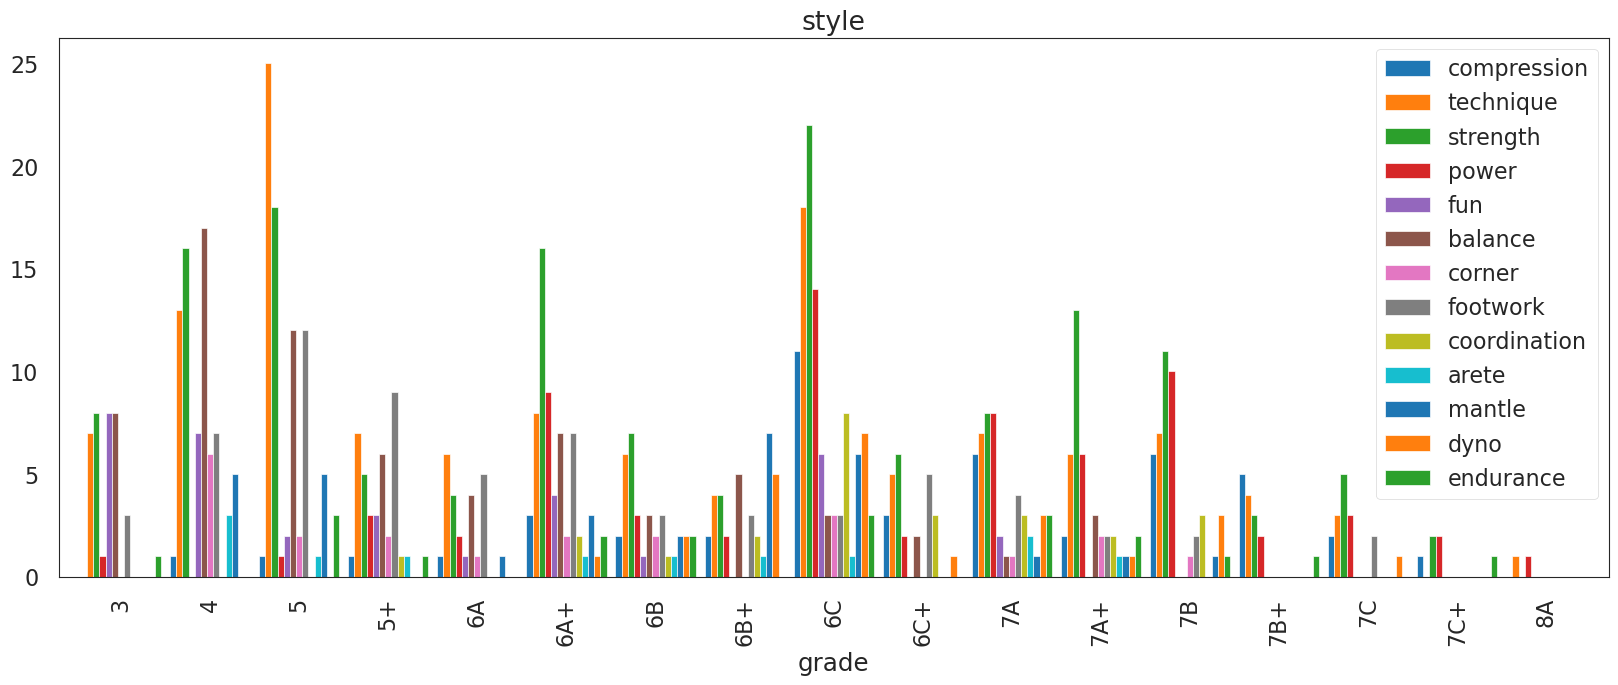

In [415]:
df_grade_style.plot(x="grade", y=list(styles.values()), kind="bar", width=0.9, figsize=(20,7), title='style')

#### More soups:

In [5]:
# user_url = 'https://beta7.app/user/bellonet'
# user_page = requests.get(user_url)
# soup_user = BeautifulSoup(user_page.text, 'html.parser')

In [ ]:
## MANUAL 

# sectors = ['Solarium', 'Enterprise', 'Dicke Berta', 'Submarino', 'Jumbo Love', 'Ekcürb', 'UFO']

# routes_hrefs = [
#     ## solarium
#     'route/hBuhKAxUX6PwJ5gi2rxqN7n8eeR2~1661788912500', #blue
#     'route/hBuhKAxUX6PwJ5gi2rxqN7n8eeR2~1661789017690', #purple
#     'route/f4nckAL9eSMtxGyPOBpMPC5Rant1~1661788937882', #black
#     ## enterprise
#     'route/UQGtEzKKf7NHJM6JGCdYL8LrkPl2~1662479556933',
#     'route/hBuhKAxUX6PwJ5gi2rxqN7n8eeR2~1662389432443',
#     'route/f4nckAL9eSMtxGyPOBpMPC5Rant1~1662389381474',
#     ## dicke berta
#     'route/UQGtEzKKf7NHJM6JGCdYL8LrkPl2~1658761877810',
#     'route/DVRZplVT6uZlilfjDrKkk343txO2~1658763312831',
#     'route/jzquGG3GoYgvvQzFrKXnzvecLwm2~1658762210519',
#     ## submarino
#     'route/jzquGG3GoYgvvQzFrKXnzvecLwm2~1662477304908',
#     'route/hBuhKAxUX6PwJ5gi2rxqN7n8eeR2~1662478024076',
#     'route/jzquGG3GoYgvvQzFrKXnzvecLwm2~1658762210519',
#     ## jumbo love
#     'route/jzquGG3GoYgvvQzFrKXnzvecLwm2~1658156156151',
#     'route/jzquGG3GoYgvvQzFrKXnzvecLwm2~1653051975825',
#     'route/jzquGG3GoYgvvQzFrKXnzvecLwm2~1653052038044',
# #     ## ekcürb
#     'route/f4nckAL9eSMtxGyPOBpMPC5Rant1~1660575179166',
#     'route/UQGtEzKKf7NHJM6JGCdYL8LrkPl2~1657038770580',
#     'route/f4nckAL9eSMtxGyPOBpMPC5Rant1~1660575342837',
#     ## ufo
#     'route/GSUDMcdZRbeDWEst1PLzaeJTfhg1~1660574616822',
#     'route/jzquGG3GoYgvvQzFrKXnzvecLwm2~1660574470641',
#     'route/jzquGG3GoYgvvQzFrKXnzvecLwm2~1660574628259'
# ]


### Set plot style params

In [4]:
attempts = ['⚡', '🥈', '👊', '❓', '✔️']
attempts
#'\U0001f948' second place

['⚡', '🥈', '👊', '❓', '✔️']

In [6]:
grade_colors = collections.OrderedDict()

grade_colors['4'] = '#fcff33'
grade_colors['5'] = '#58ff33'
grade_colors['6A'] = '#9df7f2'
grade_colors['6A+'] = '#1cacb2'
grade_colors['6B'] = '#207ea7'
grade_colors['6B+'] = '#b58de8'
grade_colors['6C'] = '#9a57a2'
grade_colors['6C+'] = '#9a23a8'
grade_colors['7A'] = '#909090'
grade_colors['7A+'] = '#616161'
grade_colors['7B'] = '#424141'
grade_colors['7B+'] = '#303030'
grade_colors['7C'] = '#000000'


# ### Beta7 grade colors - hard to distinguish:
# grade_colors['4'] = '#e8da00'
# grade_colors['5'] = '#00a476'
# grade_colors['6A'] = '#199a92'
# grade_colors['6A+'] = '#008db2'
# grade_colors['6B'] = '#1684ae'
# grade_colors['6B+'] = '#6d5e9c'
# grade_colors['6C'] = '#835498'
# grade_colors['6C+'] = '#914e95'
# grade_colors['7A'] = '#453152'
# grade_colors['7A+'] = '#382a44'
# grade_colors['7B'] = '#282132'
# grade_colors['7B+'] = '#12151a'
# grade_colors['7C'] = '#36101f'

In [7]:
## NOT USED - CURRENTLY NO HEIGHT AS HUE
# ## our min height - 158, max - 199  (starting a bit before min to not have white)
# minh = 156
# rang = 44

# cmap_discr = sns.color_palette("vlag", as_cmap=True)(np.linspace(0, 1, rang)) #red to blue
# cmap_discr = sns.color_palette("Blues", as_cmap=True)(np.linspace(0, 1, rang))

# height_colors = {i+minh:c for i,c in enumerate(cmap_discr)}
# height_colors[0] = np.array([0.5, 0.5, 0.5, 1.])

In [8]:
attempt_colors_hex = ['#009e73', '#f0e442', '#CC79A7', '#a39f9e', '#080808']

attempt_colors = {'⚡':attempt_colors_hex[0],
                  '🥈':attempt_colors_hex[1],
                  '👊':attempt_colors_hex[2],
                  '❓':attempt_colors_hex[3],
                  '✔️':attempt_colors_hex[4]}

# attempt_markers = {'⚡':'$⚡$',
#                   '🥈':'$🥈$',
#                   '👊':'$👊$',
#                   '❓':'$❓$',
#                   '✔️':'$✔️$'}

### Plot multiple routes

In [ ]:
routes_page = [requests.get(base_url + r) for r in routes_hrefs]

In [ ]:
a = BeautifulSoup(routes_page[3].text)
route_senders = [t for t in a.select(".climb-container") 
         if "<span>made a beta request</span>" not in str(t)]

In [ ]:
df = pd.DataFrame()

for i in range(len(routes_hrefs)):

    unique_route_index = i

    # entire page text:
    soup_route = BeautifulSoup(routes_page[i].text)

    # Get route name - if exists
    try:
        route_name = soup_route.select_one('.route-name').text
    except:
        route_name = 'XXX'

    # Get route level: 
    route_level = soup_route.select_one('.fb').text.split('/')

    # Get hold color:
    hold_color = soup_route.select('.color')[1].text.strip()
    if hold_color=='forest':
        hold_color = '#014421'
    elif hold_color in ['lemon','yellow']:
        hold_color = '#FFEA00'
    elif hold_color=='cornflower':
        hold_color='#9aceeb'
    #hold_color = soup_route.find('title').text.split(' ')[0]

    # List of climbers - full text per climber
    route_senders = [t for t in soup_route.select(".climb-container") 
             if "<span>made a beta request</span>" not in str(t)]
    
    # Their height
    route_heights = [int(s.select_one(".height").text[:-2]) if s.select_one(".height") else np.nan 
             for s in route_senders]

    # Their level
    route_levels = [s.select_one(".level").text[1:] if s.select_one(".level") else None 
         for s in route_senders]

    # Their number of attemps
    route_sendtype = [s.select_one(".sending-type").text if s.select_one(".sending-type") else '❓' 
              for s in route_senders]

    # Create the df
    df_route = pd.DataFrame({"height":route_heights, "levels":route_levels, 'sendtype':route_sendtype})
    df_route['idx'] = i
    df_route['name'] = route_name
    df_route['level'] = route_level[0]
    df_route['gym_level'] = route_level[1]
    df_route['hold_color'] = hold_color
    
    df = pd.concat([df, df_route])

df = df.reset_index(drop=True)
df.shape

In [ ]:
df.sendtype.unique()

In [ ]:
df = df.drop(df[df.sendtype == '🎫'].index)

df.shape, df.sendtype.unique()

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df.groupby(['idx','level']).agg({'height':["mean","median","min","max"]}).sort_values(by=['level'])

In [ ]:
df[df.idx==17]

#### X attempts, Y height, Hue sender grade

In [ ]:
nrows,ncols = len(routes_hrefs)//3,3

#fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows))

fig = plt.figure(constrained_layout=True, figsize=(5*ncols,6*nrows))

## create nrows subfigs
subfigs = fig.subfigures(nrows=len(routes_hrefs)//3, ncols=1, hspace=0.1)

for i,subfig in enumerate(subfigs):
        
        subfig.suptitle(sectors[i], fontsize=20)
        
        # create 1xncols subplots per subfig
        axs = subfig.subplots(nrows=1, ncols=ncols)
        for j, ax in enumerate(axs):

            df_route = df[df.idx == i*ncols+j]
            df_route = df_route.sort_values(by=["levels"])

            sns.swarmplot(data=df_route, x=df_route.sendtype, y=df_route.height, order=attempts, 
                          hue=df_route.levels, palette=grade_colors, ax=axs[j], size=7)

            axs[j].set_xticklabels(attempts, fontsize=30, fontproperties={'family':'Noto Emoji', 'weight':'bold'})
            axs[j].legend(fontsize=10, numpoints=1.5)            
            axs[j].set_title(f'{df_route.name.iat[0]} - {df_route.level.iat[0]}', 
                             color=df_route.hold_color.iat[0])
            axs[j].set_xlabel('')
            axs[j].set_ylabel('')
            axs[j].grid(color='#f6f6f6', linestyle='-', linewidth=2, axis='y')
            sns.despine(left=True)

plt.savefig('xAttempts_yHeight_hueLevel.png')

#### X height , Y attempts, Hue sender grade

In [ ]:
nrows,ncols = len(routes_hrefs)//3,3

#fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows))

fig = plt.figure(constrained_layout=True, figsize=(5*ncols,5*nrows))

## create nrows subfigs
subfigs = fig.subfigures(nrows=len(routes_hrefs)//3, ncols=1, hspace=0.1)

for i,subfig in enumerate(subfigs):
        
        subfig.suptitle(sectors[i], fontsize=20)
        
        # create 1xncols subplots per subfig
        axs = subfig.subplots(nrows=1, ncols=ncols)
        for j, ax in enumerate(axs):

            df_route = df[df.idx == i*ncols+j]
            df_route = df_route.sort_values(by=["levels"])
            df_route.sendtype = pd.Categorical(df_route.sendtype, 
                      categories=attempts,
                      ordered=True)

            sns.scatterplot(data=df_route, x=df_route.height, y=df_route.sendtype, 
                          hue=df_route.levels, palette=grade_colors, ax=axs[j], s=80)

            axs[j].set_yticks(attempts)
            axs[j].set_yticklabels(attempts, fontsize=25, fontproperties={'family':'Noto Emoji', 'weight':'bold'})

            ## Needed because of a bug of an extra legend item
            leg = axs[j].get_legend_handles_labels()
            axs[j].legend(leg[0][:-1],leg[1][:-1], fontsize=10, numpoints=1.5)            
            axs[j].set_title(f'{df_route.name.iat[0]} - {df_route.level.iat[0]}', 
                             color=df_route.hold_color.iat[0])
            axs[j].set_xlabel('')
            axs[j].set_ylabel('')
            sns.despine(left=True, bottom=True)
            axs[j].legend([],[], frameon=False)
            axs[j].grid(False)
            axs[j].grid(color='#f6f6f6', linestyle='-', linewidth=2, axis='x')
            
plt.savefig('xheight_yAttempts_hueLevel.png')

#### X attempts, Y sender grade, Hue height

In [ ]:
## CREATES MARKERS THAT ARE TOO SMALL
# nrows,ncols = len(routes_hrefs)//3,3

# #fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows))

# fig = plt.figure(constrained_layout=True, figsize=(5*ncols,6*nrows))

# ## create nrows subfigs
# subfigs = fig.subfigures(nrows=len(routes_hrefs)//3, ncols=1, hspace=0.1)

# for i,subfig in enumerate(subfigs):
        
#         subfig.suptitle(sectors[i], fontsize=20)
        
#         # create 1xncols subplots per subfig
#         axs = subfig.subplots(nrows=1, ncols=ncols)
#         for j, ax in enumerate(axs):

#             df_route = df[df.idx == i*ncols+j]
#             df_route = df_route.sort_values(by=["levels"])
#             df_route['height'] = df_route['height'].fillna(0)
#             df_route = df_route.astype({"height": int})

#             sns.swarmplot(data=df_route, x=df_route.sendtype, y=df_route.levels, order=attempts, 
#                           hue=df_route.height, palette=height_colors, ax=axs[j], size=6, marker="*")

#             axs[j].set_xticklabels(attempts, fontsize=30, fontproperties={'family':'Noto Emoji', 'weight':'bold'})
            
#             legend_elements = [Line2D([0], [0], marker='o', color=height_colors[0], label='-'),
#                                Line2D([0], [0], marker='o', color='w', label='Scatter', markersize=15)]
            
            
#             axs[j].legend(handles=legend_elements, fontsize=10, numpoints=1.5)            
#             axs[j].set_title(f'{df_route.name.iat[0]} - {df_route.level.iat[0]}', 
#                              color=df_route.hold_color.iat[0])
#             axs[j].set_xlabel('')
#             axs[j].set_ylabel('')
#             sns.despine(left=True)

#### X sender grade, Y attemps, Hue height

In [ ]:
## CREATES MARKERS THAT ARE TOO SMALL
# nrows,ncols = len(routes_hrefs)//3,3

# #fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows))

# fig = plt.figure(constrained_layout=True, figsize=(5*ncols,5*nrows))

# ## create nrows subfigs
# subfigs = fig.subfigures(nrows=len(routes_hrefs)//3, ncols=1, hspace=0.1)

# for i,subfig in enumerate(subfigs):
        
#         subfig.suptitle(sectors[i], fontsize=20)
        
#         # create 1xncols subplots per subfig
#         axs = subfig.subplots(nrows=1, ncols=ncols)
#         for j, ax in enumerate(axs):

#             df_route = df[df.idx == i*ncols+j]
#             df_route = df_route.sort_values(by=["levels"])
#             df_route.sendtype = pd.Categorical(df_route.sendtype, 
#                       categories=attempts,
#                       ordered=True)

#             sns.scatterplot(data=df_route, x=df_route.levels, y=df_route.sendtype, 
#                           hue=df_route.height, palette=height_colors, ax=axs[j], s=80)

#             axs[j].set_yticks(attempts)
#             axs[j].set_yticklabels(attempts, fontsize=25, fontproperties={'family':'Noto Emoji', 'weight':'bold'})

#             ## Needed because of a bug of an extra legend item
#             leg = axs[j].get_legend_handles_labels()
#             axs[j].legend(leg[0][:-1],leg[1][:-1], fontsize=10, numpoints=1.5)            
#             axs[j].set_title(f'{df_route.name.iat[0]} - {df_route.level.iat[0]}', 
#                              color=df_route.hold_color.iat[0])
#             axs[j].set_xlabel('')
#             axs[j].set_ylabel('')
#             #sns.despine(left=True)

#### X sender grade, Y height, Hue attempts

In [ ]:
### DOESNT LOOK GOOD
# from matplotlib.path import Path
# from matplotlib.textpath import TextToPath
# from matplotlib.font_manager import FontProperties

# fp = FontProperties(family='Noto Emoji', weight='bold')

# def get_marker(symbol):
#     v, codes = TextToPath().get_text_path(fp, symbol)
#     v = np.array(v)
#     mean = np.mean([np.max(v,axis=0), np.min(v, axis=0)], axis=0)
#     return Path(v-mean, codes, closed=False)

In [ ]:
nrows,ncols = len(routes_hrefs)//3,3

#fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows))

fig = plt.figure(constrained_layout=True, figsize=(5*ncols,6*nrows))

## create nrows subfigs
subfigs = fig.subfigures(nrows=len(routes_hrefs)//3, ncols=1, hspace=0.1)

for i,subfig in enumerate(subfigs):
        
        subfig.suptitle(sectors[i], fontsize=20)
        
        # create 1xncols subplots per subfig
        axs = subfig.subplots(nrows=1, ncols=ncols)
        for j, ax in enumerate(axs):

            df_route = df[df.idx == i*ncols+j]
            df_route = df_route.sort_values(by=["levels"])

            sns.scatterplot(data=df_route, x=df_route.levels, y=df_route.height,
                          hue=df_route.sendtype,# style=df_route.sendtype, #marker=get_marker('🥈')
                            palette=attempt_colors, ax=axs[j], s=80) 

            axs[j].xaxis.set_tick_params(labelsize=15)
            axs[j].legend([])            
            axs[j].set_title(f'{df_route.name.iat[0]} - {df_route.level.iat[0]}', 
                             color=df_route.hold_color.iat[0])
            axs[j].set_xlabel('')
            axs[j].set_ylabel('')
            axs[j].grid(color='#f6f6f6', linestyle='-', linewidth=2)
            sns.despine(left=True)

plt.savefig('xLevel_yHeight_hueAttempts.png')

In [ ]:
sns.palplot(attempt_colors_hex)
ax = plt.gca()
for i, name in enumerate(attempts):
    ax.text(i-0.35, 0.15, name, c='white', size=30, fontproperties={'family':'Noto Emoji', 'weight':'bold'}) 
    
plt.savefig('hueAttempts.png')